<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/GoodShakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import requests

url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
text = requests.get(url)

In [132]:
import random

In [133]:
text = text.text

In [134]:
text = text.lower()
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for ele in text:
    if ele in punc:
        text = text.replace(ele, "")

In [135]:
vocab = text.split()

In [136]:
vocab_dict = set()
for word in vocab:
  if random.randint(1, 100) > 85:
    vocab_dict.update([word])

In [137]:
len(vocab_dict)

4711

In [138]:
vocab_dict = sorted(vocab_dict)

In [139]:
stoi = {"[PAD]": 0, "[UNK]": 1}
itos = {0: "[PAD]", 1: "[UNK]"}
stoi.update({char:i+2 for i, char in enumerate(vocab_dict)})
itos.update({i+2:char for i, char in enumerate(vocab_dict)})

In [140]:
stoi['a']

3

In [141]:
itos[stoi['a']]

'a'

In [142]:
class Tokenizer:
  def __init__(self, stoi, itos, len=10):
    self.stoi = stoi
    self.itos = itos
    self.len = len
  def encode(self, text, crop=True, pad=True):
    out = []
    if crop:
      for word in text.lower().split()[:self.len]:
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
    else:
      for word in text.lower().split():
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
  def decode(self, ids):
    out = ""
    for id in ids:
      if (id in self.itos) and id != 1:
        out += self.itos[id] + " "
      elif id==0:
        out += '[PAD]'
      else:
        out += '[UNK] '
    return out

In [143]:
tokenizer = Tokenizer(stoi, itos)

In [144]:
tokenizer.encode("hello world", pad=False)

[1, 4643]

In [145]:
tokenizer.decode(tokenizer.encode("hello world", pad=False))

'[UNK] world '

In [146]:
import torch

In [147]:
import torch.nn.functional as F

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [149]:
num_epochs = 100000
lr = 10
batch_size = 256

In [150]:
context_len = 3
emb_dim = 20
vocab_size = len(stoi)
n_hidden = 400
C = torch.randn(vocab_size, emb_dim).to(device)
w1 = torch.randn(context_len * emb_dim, n_hidden).to(device) * 0.1
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn(n_hidden, vocab_size).to(device) * 0.1
b2 = torch.randn(vocab_size).to(device) * 0.01

params = [C, w1, b1, w2, b2]
for p in params:
  p.requires_grad = True

tokenizer = Tokenizer(stoi, itos, len=context_len)

In [151]:
def build_dataset(text):
  xs = []
  ys = []
  tokenized_text = tokenizer.encode(text, crop=False)
  context = [0] * (context_len)
  for x in tokenized_text:
    xs.append(context)
    ys.append(x)
    context = context[1:] + [x]
  xs = torch.tensor(xs).to(device)
  ys = torch.tensor(ys).to(device)
  return xs, ys
Xtr, Ytr = build_dataset(text)
train_examples = len(Xtr) - 1

In [152]:
epochs = torch.arange(num_epochs)
losses = []

In [153]:
for epoch in range(num_epochs):
  batch_indices = torch.randint(0, train_examples, (batch_size, ))
  xs = Xtr[batch_indices]
  ys = Ytr[batch_indices]
  emb = C[xs].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  logits = (l1 @ w2 + b2).tanh()
  loss = F.cross_entropy(logits, ys)

  losses.append(loss.item())

  for p in params:
    p.grad = None

  loss.backward()

  for p in params:
    p.data -= p.grad * (lr * ((epoch+1) ** -0.5))

  if epoch % 10000 == 0:
    print("Epoch", str(epoch) + ", loss:", loss.item())


Epoch 0, loss: 8.635568618774414
Epoch 10000, loss: 7.089189529418945
Epoch 20000, loss: 7.123117923736572
Epoch 30000, loss: 7.10128116607666
Epoch 40000, loss: 7.117026329040527
Epoch 50000, loss: 7.02869987487793
Epoch 60000, loss: 7.054577350616455
Epoch 70000, loss: 7.034709930419922
Epoch 80000, loss: 6.982211112976074
Epoch 90000, loss: 7.073363304138184


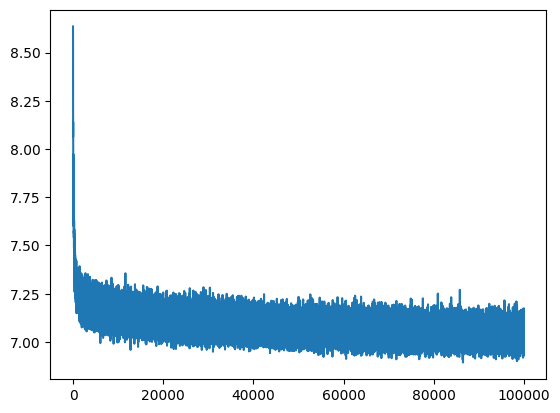

In [154]:
import matplotlib.pyplot as plt

plt.plot(epochs.numpy(), losses)

In [155]:
Xtr[100]

tensor([1988, 4059, 4657], device='cuda:0')

In [156]:
Ytr[100]

tensor(4691, device='cuda:0')

In [157]:
tokenizer.decode([Ytr[100].cpu().numpy().item()])

'yield '

In [158]:
tokenizer.decode(Xtr[100].cpu().numpy())

'if they would '

In [159]:
def prompt(text, len=10):
  output = text + " "
  for x in range(len):
    xs = torch.tensor(tokenizer.encode(output)).to(device)
    emb = C[xs].view(-1, emb_dim * context_len)
    l1 = (emb @ w1 + b1).tanh()
    logits = (l1 @ w2 + b2).tanh()
    outs = logits.softmax(dim=1)
    selected = torch.multinomial(outs, num_samples=1)[0].cpu().numpy()
    outchar = tokenizer.decode(selected)
    output += outchar
  return output

In [160]:
def get_likelihood(input, expected):
  emb = C[input].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  logits = (l1 @ w2 + b2).tanh()
  outs = logits.softmax(dim=1)
  print(outs.shape)
  print("Max:", outs[0].argmax(), outs[0][outs.argmax()])
  return outs[0][expected]

In [161]:
get_likelihood(Xtr[100], Ytr[100])

torch.Size([1, 4713])
Max: tensor(1, device='cuda:0') tensor(0.0012, device='cuda:0', grad_fn=<SelectBackward0>)


tensor(0.0010, device='cuda:0', grad_fn=<SelectBackward0>)

In [162]:
prompt("romeo")

'romeo whats so little else ten jacob traitors sinking respecting be '

In [163]:
prompt(tokenizer.decode(Xtr[100].cpu().numpy()))

'if they would  offences recorder madam misshaped feard ifs fairy thomas prosperous words '

In [164]:
prompt("", len=100)

' boring thrice boat crabtrees bush mean wounds petruchio ram an picture bleated needs asketh standerby storms cleomenes rebelld gentlewoman sail disgrace hood moisture attaind judge unreal keeper tod brine sedition cousins shop took defiance win this women took this trim worship amended fifes ordained called helping war saints blessed yes several grim nor couple favourites loan therefore guard lights leanwitted tutors mine cats love air set sinister montague flote passing thus romeo distinction commission supreme hungry resolute cicester summer marquess never magic shall even accident montgomery effect are belongs heavenly cry admitted naught see whiles earthly swoln earldom twenty where '